In [10]:
import math
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets

SyntaxError: invalid syntax (1956291251.py, line 7)

Реалізація функції лагерра

In [2]:
# 2
def laguerre(t, n, beta=2, sigma=4):
    l0 = np.sqrt(sigma) * (np.exp(-beta * t / 2))
    l1 = np.sqrt(sigma) * (1 - sigma * t) * (np.exp(-beta * t / 2))
    if n == 0:
        return l0
    elif n == 1:
        return l1
    elif n >= 2:
        l_n = (2 * 2 - 1 - t * sigma) / 2 * l1 - (2 - 1) / 2 * l0
    for i in range(3, n + 1):
        l0 = l1
        l1 = l_n
        l_n = (2 * i - 1 - sigma * t) / i * l1 - l0 * (i - 1) / i
    return l_n


lagg = laguerre(3, 9)
print(lagg)

6.551978197210897


Функція для перетворення Лагерра

In [3]:
# 3
def transform_laguerre(f, max_n, beta=2, sigma=4):
    def integrated_function(t):
        return f(t) * laguerre(t, max_n, beta, sigma) * np.exp(-t * (sigma - beta))

    max_t, df = experiment(max_n)
    return integral(integrated_function, 0, max_t)

Функція для осбчислювання значень інтегралів, обернене перетворення Лагерра

In [4]:
# 4
def integral(f, a, b):
    x = np.linspace(a, b, 1000)
    s = sum([f(i) for i in x])
    return s * abs(b - a) / 1000

def inverse_laguerre_transform(hk, t):
    n = len(hk) - 1  
    result = 0
    for k in range(n + 1):
        result += hk[k] * laguerre(t, k)  
    return result


hk = [1, 2, 3, 4, 5] 
t_values = np.linspace(0, 10, 100)
h_values = [inverse_laguerre_transform(hk, t) for t in t_values]
ht = inverse_laguerre_transform(h_values, t_values)
print(hk)


[1, 2, 3, 4, 5]


Графік функцій Лагерра з віджетом для вибору n

In [5]:
# 5.1

def plot_laguerre(n):
    t_values = np.linspace(0, 10, 100)
    laguerre_values = [laguerre(t, n, beta=2, sigma=4) for t in t_values]

    plt.figure(figsize=(8, 6))
    plt.plot(t_values, laguerre_values, label=f'L_{n}(t)', color="black")
    plt.xlabel('t')
    plt.ylabel(f'L_{n}(t)')
    plt.title(f'Графік функції Лагерра L_{n}(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

n_widget = widgets.IntSlider(value=0, min=0, max=20, step=1, description='n:')

widgets.interactive(plot_laguerre, n=n_widget)


interactive(children=(IntSlider(value=0, description='n:', max=20), Output()), _dom_classes=('widget-interact'…

Графік для табулювання Лагерра та функція табулювання

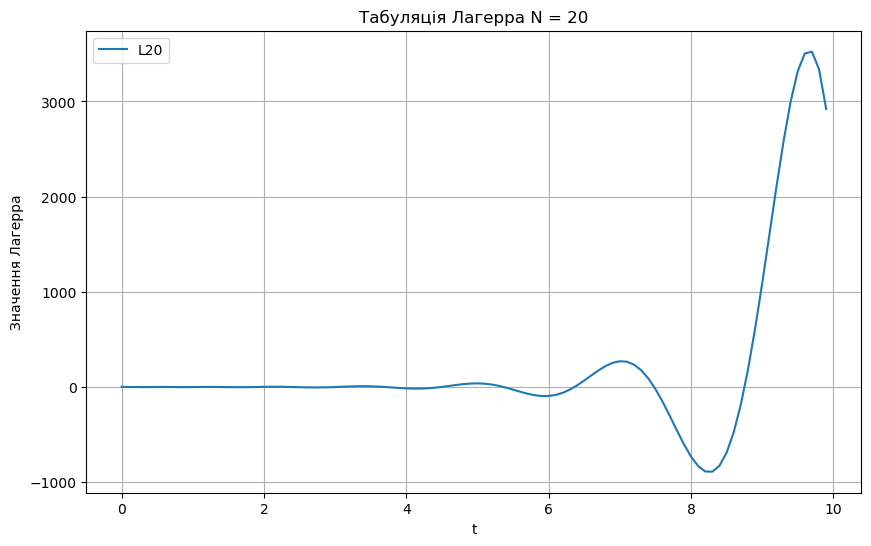

In [6]:
# 5.2
def laguerre_tabulation(n, max_t, beta=2, sigma=4):
    T = np.arange(0, max_t, 0.1)
    return pd.DataFrame(
        data={
            't': T,
            f'L{n}': [laguerre(t, n, beta, sigma) for t in T]
        }
    ).set_index('t')

N = 20
beta = 2
sigma = 4
T = 10

df = laguerre_tabulation(N, T, beta, sigma)

plt.figure(figsize=(10, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)

plt.title(f'Табуляція Лагерра N = {N}')
plt.xlabel('t')
plt.ylabel('Значення Лагерра')
plt.legend()
plt.grid(True)
plt.show()

Обчислювальний експеримент, побудова таблички, віджети

In [7]:
# 5.3
def experiment(max_n=20, eps=1e-3, max_t=100):
    T = np.linspace(0, max_t, 1000)
    N = range(0, max_n + 1)
    result = None
    for t in T:
        if t is None:
            continue
        condition_met = True
        for n in N:
            if abs(laguerre(t, n)) > eps:
                condition_met = False
                break
        if condition_met and result is None:
            result = t
            break

    if result is not None:
        N = range(0, max_n + 1)
        return result, pd.DataFrame(
            data={
                'n': N,
                'Ln': [laguerre(result, n) for n in N]
            }
        ).set_index('n')
    else:
        return None, None


max_n_slider = widgets.IntSlider(min=1, max=50, value=20, description='Max n:')
eps_slider = widgets.FloatSlider(min=1e-4, max=1, step=1e-4, value=1e-3, description='Eps:')
max_t_slider = widgets.FloatSlider(min=10, max=200, step=10, value=100, description='Max t:')

def update_experiment(max_n, eps, max_t):
    result, df = experiment(max_n, eps, max_t)
    if result is not None:
        print(f"Result: {result}")
        display(df)

widgets.interactive(update_experiment, max_n=max_n_slider, eps=eps_slider, max_t=max_t_slider)

interactive(children=(IntSlider(value=20, description='Max n:', max=50, min=1), FloatSlider(value=0.001, descr…

Обчислюємо наближений інтеграл за методом прямокутників, потім підінтегральної функції і будуємо функцію для обчислення значень інтегралів наближено за даною формулою

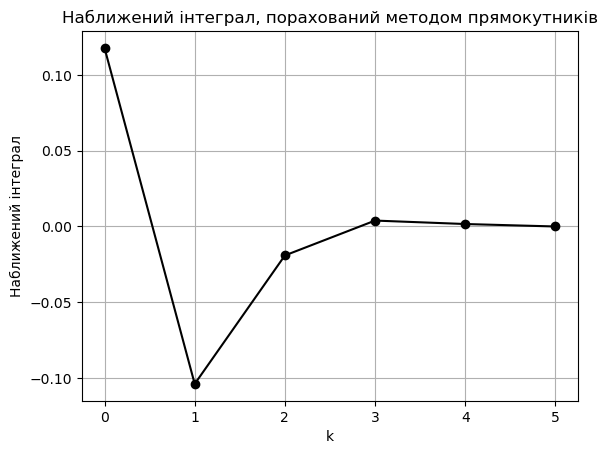

In [8]:
# 5.4
def approximate_integral(f, k, alpha, T, num_rectangles):
    delta_t = T / num_rectangles
    integral_approximation = 0

    for i in range(num_rectangles):
        t_start = i * delta_t
        t_end = (i + 1) * delta_t
        t_mid = (t_start + t_end) / 2


        integrand = f(t_mid) * laguerre(t_mid, k) * np.exp(-alpha * t_mid)
        integral_approximation += integrand * delta_t

    return integral_approximation


alpha = 2
max_k = 5
T = 10
num_rectangles = 1000


def f(t):
    return np.exp(-t) * np.sin(t)


k_values = list(range(max_k + 1))
integral_approximations = [approximate_integral(
    f, k, alpha, T, num_rectangles) for k in k_values]

plt.plot(k_values, integral_approximations, marker='o', linestyle='-', color = "black")
plt.xlabel('k')
plt.ylabel('Наближений інтеграл')
plt.title('Наближений інтеграл, порахований методом прямокутників')
plt.grid(True)
plt.show()

Шукаємо коефіцієнти при N = 20

In [9]:
#5.5
def f(t):
    if 0 <= t <= 2 * np.pi:
        return np.sin(t - np.pi / 2) + 1
    else:
        return 0
    
N = 20
alpha = 2
laguerre_coeffs = transform_laguerre(f, alpha, N)
data = {'f_k': [f"f_{k}" for k in range(N + 1)], 'coefficients': laguerre_coeffs}
df = pd.DataFrame(data)
data_slider = widgets.SelectionSlider(options = df['f_k'].unique(), description = "Select coefficient:")
widgets.interactive(lambda k: display(df[df['f_k'] == k]['coefficients'].to_string(index=False, header=False)), k = data_slider)


interactive(children=(SelectionSlider(description='Select coefficient:', options=('f_0', 'f_1', 'f_2', 'f_3', …

In [11]:
# рандомна функція
def g(t):
    if 0 <= t <= 2 * np.pi:
        return np.cos(t - np.pi / 2) + 1
    else:
        return 0

transform_laguerre(g, 20)


0.15492010687545313

Обчислюємо значення оберненого перетворення Лагерра для заданого набору коефіцієнтів

In [12]:
#5.6
hk = [1, 2, 3, 4, 5]
t = 2.5
h_t = inverse_laguerre_transform(hk, t)
print(f"h^N({t}) = {h_t}")


h^N(2.5) = -8.482116524469543


Побудова функції Лагерра для кожного значення у вказаному діапазоні

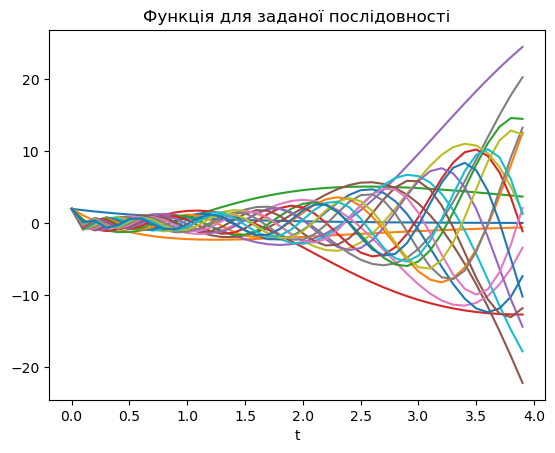

In [13]:
#5.7
def polynomial_laguerre_plot(max_t, n_max):
    for n in range(0, n_max + 1):
        l_n_tabulation = laguerre_tabulation(n, max_t)
        plt.plot(l_n_tabulation.index, l_n_tabulation[f'L{n}'], label=f'L_{n}')

    plt.title('Функція для заданої послідовності')
    plt.xlabel('t')

    plt.show()
    
polynomial_laguerre_plot(4, 20)

Для кожного N обчислюються коефіцієнти перетворення Лагерра та значення f^N(t)

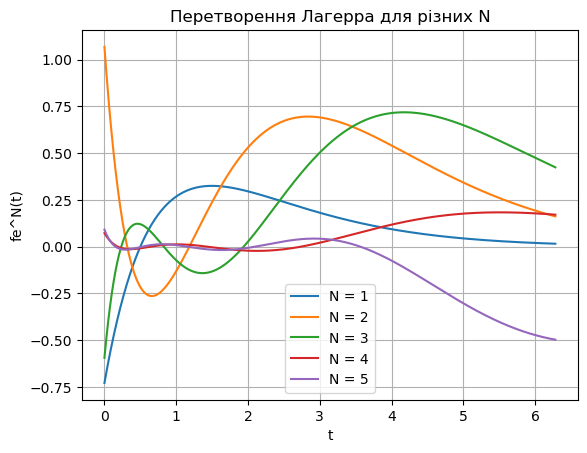

In [14]:
#5.8
def transform_laguerre(f, max_n, beta=2, sigma=4):
    def integrated_function(t):
        return f(t) * laguerre(t, max_n, beta, sigma) * np.exp(-t * (sigma - beta))

    max_t, df = experiment(max_n)
    hk = [integral(integrated_function, 0, max_t) for _ in range(max_n + 1)]
    return hk

N_values = [1, 2, 3, 4, 5]
t_values = np.linspace(0, 2 * np.pi, 1000)

for N in N_values:
    hk = transform_laguerre(f, N)
    fN_values = [inverse_laguerre_transform(hk, t) for t in t_values]

    plt.plot(t_values, fN_values, label=f"N = {N}")

plt.xlabel('t')
plt.ylabel('fe^N(t)')
plt.title("Перетворення Лагерра для різних N")
plt.legend()
plt.grid(True)
plt.show()
